## En construcción (no puedo hacer andar los Nedelec) ##

# Capacity Project

Writen by: Oscar Reula (oreula@gmail.com)

This code is writen in Fenics/Python, it is used to compute the resonant frequencies and eigenvectors of a cavity. At the moment is 2-dimensional, that is it corresponds to infinite long structures in the  ẑ direction. 
This restriction is mainly due to have a code that can run in home computers in very short time.

First the theory: we need to solve the following eigenfuntion problem for the electric field:

$\nabla \wedge (\nabla \wedge \vec{E})  = \lambda \vec{E} \quad\quad\text{ in $\Omega$}$

$\vec{E} \wedge \hat{n}= 0 \text{ on $\partial\Omega$}$

Where $\Omega$ is some 2-dimensional region, we think for this problem as the electric field having zero $\hat{z}$ component. Here $\lambda = \frac{\omega^2}{c^2}$ with $\omega$ the mode frequency and $c$ the speed of light.
Notice that if the take the divergence of the right hand side of the equation we get identically zero, thus, all the modes must have zero divergence, but also implies that the operator at the right hand side has a big kernel.
Thus, to solve the problem as a variational one we must restrict the space to that of vectors with zero divergence.
It is only in this space that the operator is elliptic.

In order to use finite elements we need to express the problem as a weak one:

$$
\int_{\Omega} \nabla \wedge \vec{E}\,\cdot \nabla \wedge \vec{V}\, {\rm d} x
= \lambda \int_{\Omega} \vec{E} \cdot \vec{V}\, {\rm d} x \quad \forall \ \vec{V}\in H_0(\nabla \wedge),
$$

Where the space $H_0(\nabla \wedge)$ is the space of vectors which have zero divergence. 

We shall have a test case, namely:

$\nabla \wedge (\nabla \wedge \vec{E})  = \lambda \vec{E} \quad\quad\text{ in $\Omega$} \quad\quad\quad
\Omega = (0,\pi)\times(0,\pi)$

For this case we know the solutions: (see for instance: http://www.famaf.unc.edu.ar/~reula/Docencia/Electromagnetismo/electrodynamics.pdf, Sec. 19.1)

$\vec{E}(x,y) = (m\cos(n x)\sin(m y), -n\cos(m y)\sin(n x)), \quad \lambda = m^2 + n^2,$ $\quad \lambda = 1, 1, 2, 4, 4, 5, 5, 8, 9, 9, 10, 10, 13, 13, \dots$

We use this case to check that what we are doing is correct. 

We are going to compute the eigenvectors for regions with several disconected boundaries. In that case there are an infinite set of zero mode solutions. The equations for the zero modes are just Laplace's equation for a potential,
where the boundary condition is that in each boundary the potential is constant. That problem as a n-parameter family of solutions, where the parameters are the potential's value at the n boundaries. Taking out a normalization constant we see that there remain n-1 parameters in the continuum. If the potentials are not all equal we then have a non-zero electric field and so a zero-mode for each set of parameter values.

In [1]:
using Gridap
using Gridap.FESpaces
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
using gmsh
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack

In [2]:
n = 20
domain = (0,π,0,π)
partition = (n,n)
model = CartesianDiscreteModel(domain, partition)

labels = get_face_labeling(model)
add_tag_from_tags!(labels,"diri_all",[1,2,3,4,5,6,7,8]);
dirichlet_tags=["diri_all"]
#dirichlet_values = [0.0,0.0]
dirichlet_values = VectorValue(0.0,0.0)

VectorValue{2, Float64}(0.0, 0.0)

In [3]:
Ω = Triangulation(model)
degree = 2
dΩ = Measure(Ω,degree)

Measure()

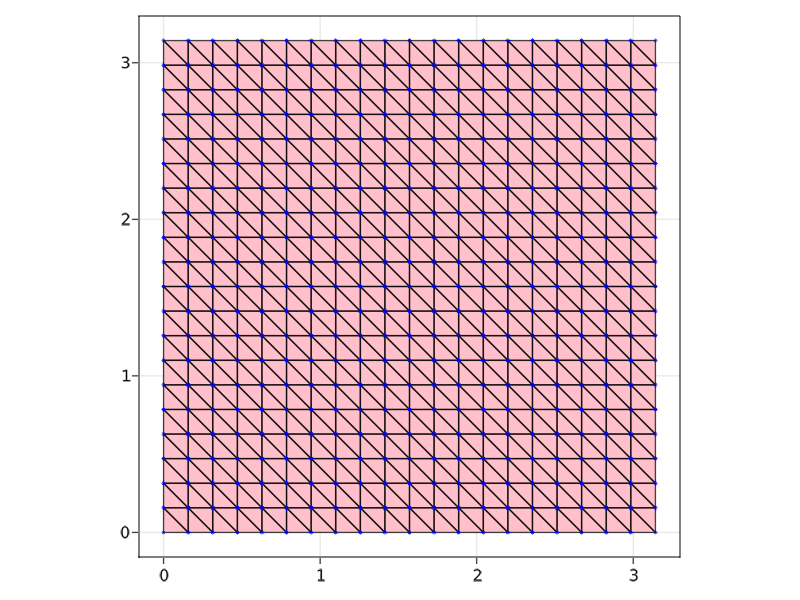

In [4]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

In [5]:
D = 2
order = 2
reffeₑ = ReferenceFE(lagrangian, VectorValue{2,Float64}, order) #THIS WORKS
#reffeₑ = ReferenceFE(lagrangian, VectorValue{2,Complex64}, order) #THIS DOES NOT WORKS
#reffeₑ = ReferenceFE(raviart_thomas,Float64,order) #THIS WORKS
#reffeₑ = ReferenceFE(nedelec,Float64,order) #DOES NOT WORK
V = FESpace(model, reffeₑ,vector_type=Vector{ComplexF64}
    , conformity=:H1
    #, conformity=:Hdiv
    #, conformity=:HCurl
    , dirichlet_tags=dirichlet_tags)

U = TrialFESpace(V,dirichlet_values)

TrialFESpace()

In [6]:
a(u,v) = ∫( (∇×v)⋅(∇×u) )*dΩ

a (generic function with 1 method)

In [7]:
m(u,v) = ∫(u⋅v)dΩ

m (generic function with 1 method)

In [8]:
include("eigen.jl")

solve (generic function with 1 method)

In [9]:
nev = 100 # number of eigenvalues asked to evaluate.
#prob = EigenProblem(a, m, U, V; nev=nev )
prob = EigenProblem(a, m, U, V; nev=nev, which=:LM, explicittransform=:auto, tol=10^(-6), maxiter=100, sigma=2.)
ξ, uₕs = solve(prob);

In [10]:
ξ

100-element Vector{ComplexF64}:
     1.9966741882854675 + 2.731614830879446e-16im
     1.0000016886541512 + 5.551096375314419e-16im
     1.0000016886537555 - 6.103708019481801e-13im
 2.2715740399803508e-10 - 1.0796016855819743e-11im
   5.60369528557203e-11 - 2.1519558215670462e-12im
 4.3574477359697994e-11 - 9.807810051590249e-13im
  3.367528478293025e-11 + 1.473661779583393e-11im
 3.2155611506823334e-11 - 2.892064354676527e-12im
  2.602718041089247e-11 - 1.5062916191740245e-12im
  2.362288142876423e-11 - 1.8260687272901196e-12im
 2.1510349057507483e-11 - 1.3538488799705906e-12im
 1.9193979738929556e-11 + 1.8951507029987665e-12im
 1.8208101693062417e-11 + 5.005976784815436e-13im
                        ⋮
      36.07516453443745 + 1.196444682565426e-12im
      36.07516453444165 - 6.783271516102372e-12im
     37.014127242393016 + 8.13182040098274e-13im
      37.01412724239589 + 3.828153751953073e-14im
      40.07527213889809 + 7.004317959279076e-14im
      40.07527213890474 + 3.417211240

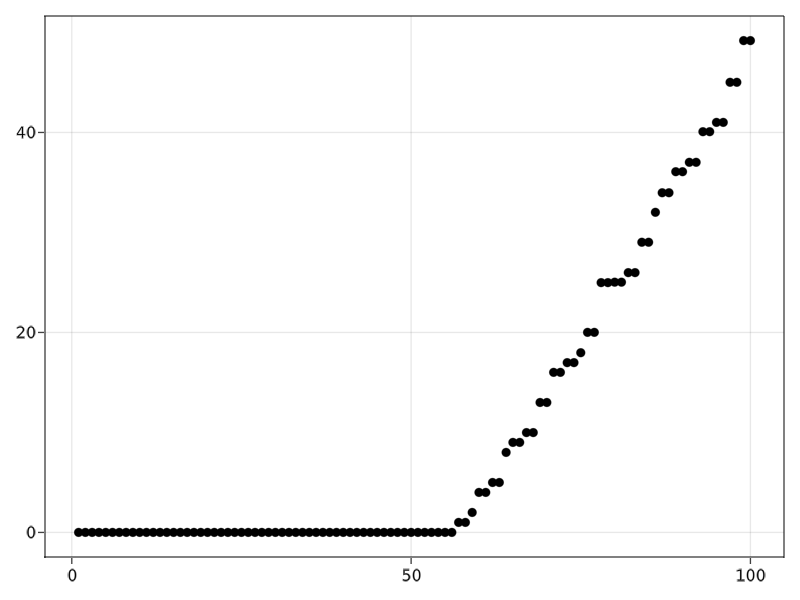

In [11]:
plot(sort(real(ξ)))

In [12]:
uₕ = uₕs[4]
fig, ax, plt = plot(Ω, ( u-> real(u[1])) ∘ uₕ)
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

Figure()

In [13]:
l = 5
uₕ = uₕs[l]
writevtk(Ω,"eigenvector_$l",order=1,cellfields=["e_1"=>( u-> real(u[1])) ∘ uₕ, "e_2"=>( u-> real(u[2])) ∘ uₕ])


(["eigenvector_5.vtu"],)